In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import regex as re
from wordcloud import WordCloud,STOPWORDS
import io

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
songs = pd.read_csv('/content/lyrics.csv' , usecols=['Album','Song','Lyrics','views'])
songs.head(4)

,Album,Song,Lyrics,views
0,Make Out,ILYSB,[Verse]\r\nAin't never felt this way\r\nCan't ...,192.1K
1,Make Out,Walk Away,[Verse]\r\nYou and I would be just fine\r\nIf ...,78.9K
2,Make Out,"Bad, Bad, Bad",[Verse]\r\nBack to high school love\r\nThe kin...,62.1K
3,Make Out,Made in Hollywood,"[Verse]\r\nTurn off the lights, come and lay w...",59K


In [70]:
preprocessed = songs.copy()
for col in preprocessed.columns[:-1]:
    preprocessed[col] = preprocessed[col].str.lower()

In [71]:
def view_preprocess(s):
    if type(s)!= float:
        if s[-1]=='K':
            return float(s.replace('K',''))*1000
preprocessed.views = preprocessed.views.apply(view_preprocess)

In [72]:
preprocessed.Song = preprocessed.Song.apply(lambda x:re.sub(r'[^\w\s]', '', x) )

In [73]:
preprocessed = preprocessed.loc[preprocessed.Lyrics.dropna().index,:]
preprocessed['number_of_verses']=0
preprocessed['number_of_chorus']=0
preprocessed.loc[preprocessed.Lyrics.notna().index,'number_of_verses'] = preprocessed.Lyrics[preprocessed.Lyrics.notna()].apply(lambda x:len( re.findall(r'verse',x)))
preprocessed.loc[preprocessed.Lyrics.notna().index,'number_of_chorus'] = preprocessed.Lyrics[preprocessed.Lyrics.notna()].apply(lambda x:len( re.findall(r'chorus',x)))

In [74]:
preprocessed.loc[preprocessed.Lyrics.notna().index,'Lyrics'] = preprocessed.Lyrics[preprocessed.Lyrics.notna()].apply(lambda x: re.sub(r'\[([^]]*)]','',x))
preprocessed.loc[preprocessed.Lyrics.notna().index,'Lyrics'] = preprocessed.Lyrics[preprocessed.Lyrics.notna()].apply(lambda x:re.sub(r'[^\w\s]', '', x))
preprocessed.loc[preprocessed.Lyrics.notna().index,'Lyrics'] = preprocessed.Lyrics[preprocessed.Lyrics.notna()].apply(lambda x:re.sub(r'verse', '', x))
preprocessed.loc[preprocessed.Lyrics.notna().index,'Lyrics'] = preprocessed.Lyrics[preprocessed.Lyrics.notna()].apply(lambda x: re.sub(r'pre-chorus','',x))
preprocessed.loc[preprocessed.Lyrics.notna().index,'Lyrics'] = preprocessed.Lyrics[preprocessed.Lyrics.notna()].apply(lambda x:re.sub(r'chorus', '', x))

In [75]:
sid = SIA()
preprocessed['sentiments']           = preprocessed['Lyrics'].apply(lambda x: sid.polarity_scores(x))
preprocessed['Positive Sentiment']   = preprocessed['sentiments'].apply(lambda x: x['pos'])
preprocessed['Neutral Sentiment']    = preprocessed['sentiments'].apply(lambda x: x['neu'])
preprocessed['Negative Sentiment']   = preprocessed['sentiments'].apply(lambda x: x['neg'])

In [76]:
preprocessed['#characters'] = preprocessed['Lyrics'].apply(lambda x: len(x))


In [81]:
preprocessed['# Of words'] = preprocessed['Lyrics'].apply(lambda x: len(x.split(' ')))
preprocessed['# of lines'] = preprocessed['Lyrics'].apply(lambda x: len(x.split('\r\n')))
preprocessed['Average Word Length Per Line']   = preprocessed['# Of words']/preprocessed['# of lines']
preprocessed['#uniq_words'] = preprocessed['Lyrics'].apply(lambda x: len(set(x.split())))
preprocessed['lexical_density'] = preprocessed['#uniq_words'] / preprocessed['# Of words']

In [82]:
preprocessed.head()

,Album,Song,Lyrics,views,number_of_verses,number_of_chorus,sentiments,Positive Sentiment,Neutral Sentiment,Negative Sentiment,#characters,# Of words,# of lines,Average Word Length Per Line,#uniq_words,lexical_density
0,make out,ilysb,\r\naint never felt this way\r\ncant get enoug...,192100.0,2,6,"{'neg': 0.305, 'neu': 0.51, 'pos': 0.186, 'com...",0.186,0.510,0.305,1164,211,53,3.981132,76,0.360190
1,make out,walk away,\r\nyou and i would be just fine\r\nif i was t...,78900.0,2,3,"{'neg': 0.013, 'neu': 0.488, 'pos': 0.498, 'co...",0.498,0.488,0.013,1003,173,48,3.604167,44,0.254335
2,make out,bad bad bad,\r\nback to high school love\r\nthe kind witho...,62100.0,2,3,"{'neg': 0.273, 'neu': 0.635, 'pos': 0.092, 'co...",0.092,0.635,0.273,1178,202,54,3.740741,84,0.415842
3,make out,made in hollywood,\r\nturn off the lights come and lay with me\r...,59000.0,2,5,"{'neg': 0.009, 'neu': 0.661, 'pos': 0.33, 'com...",0.330,0.661,0.009,994,136,61,2.229508,78,0.573529
4,make out,kiss,\r\nthe sun is down\r\nyoure not around wait a...,15800.0,2,4,"{'neg': 0.233, 'neu': 0.609, 'pos': 0.157, 'co...",0.157,0.609,0.233,1015,193,38,5.078947,55,0.284974


In [83]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Perason Correaltion',  'Spearman Correaltion'))

s_val =preprocessed.corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',showscale=False,xgap=1,ygap=1),
    row=1, col=1
)

s_val =preprocessed.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=1,ygap=1),
    row=2, col=1
)
fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)
fig.update_layout(height=700, width=900, title_text="Correlations Between Different Numeric Features")
fig.show()

<ipython-input-97-01d654c809e3>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-97-01d654c809e3>:12: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



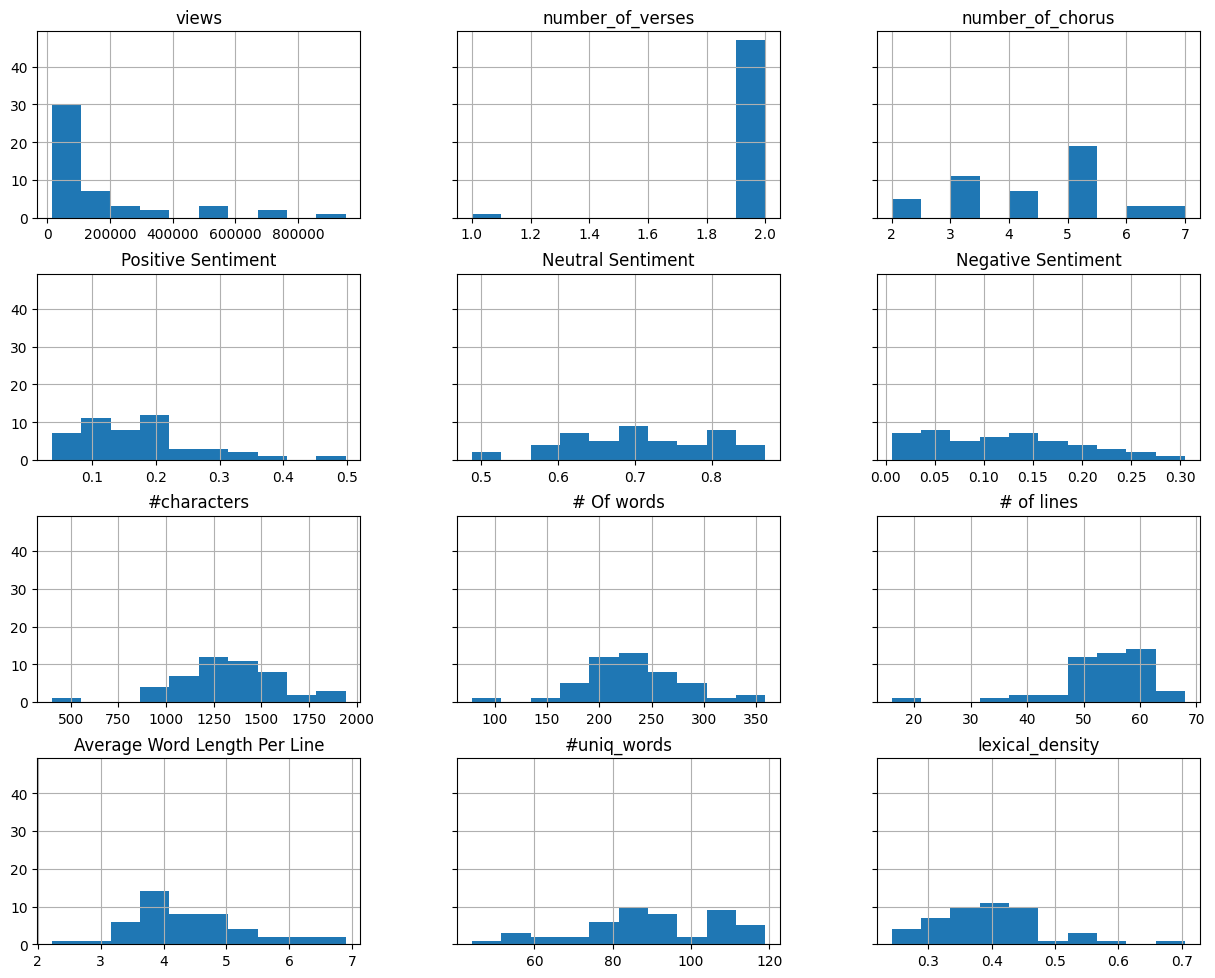

In [85]:
preprocessed.hist(sharey=True, layout=(5, 3), figsize=(15, 15));

<Axes: title={'center': 'Most Common Words'}>

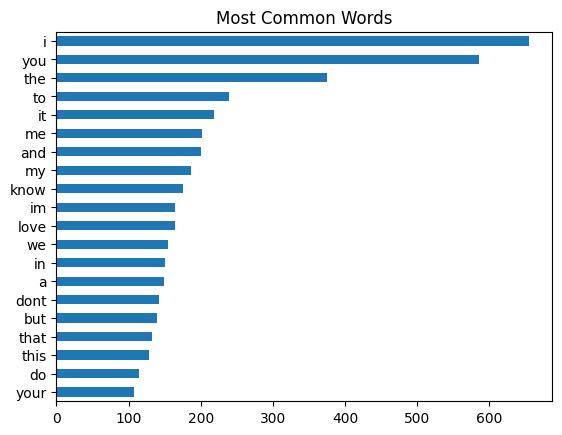

In [103]:
pd.Series(' '.join(preprocessed.Lyrics[preprocessed.Lyrics.notna()]).lower().split()).value_counts()[:20][::-1].plot(kind='barh', title = 'Most Common Words')

Most common complex word (length of word > 7)

<Axes: title={'center': 'Most complex word'}>

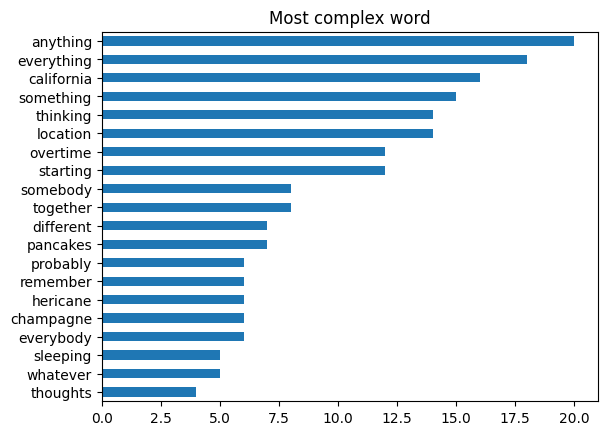

In [104]:
pd.Series([w for w in ' '.join(i for i in ' '.join(preprocessed.Lyrics[preprocessed.Lyrics.notna()]).lower().split("\r\n")).split() if len(w) > 7]).value_counts()[:20][::-1].plot(kind='barh', title = "Most complex word")

In [17]:
from nltk import ngrams

In [18]:
def get_ngrams_from_series(series, n=2):
    # using nltk.ngrams
    lines = ' '.join(series).lower().split('\n')
    lgrams = [ngrams(l.split(), n) for l in lines]
    grams = [[' '.join(g) for g in list(lg)] for lg in lgrams]
    return [item for sublist in grams for item in sublist]

<Axes: >

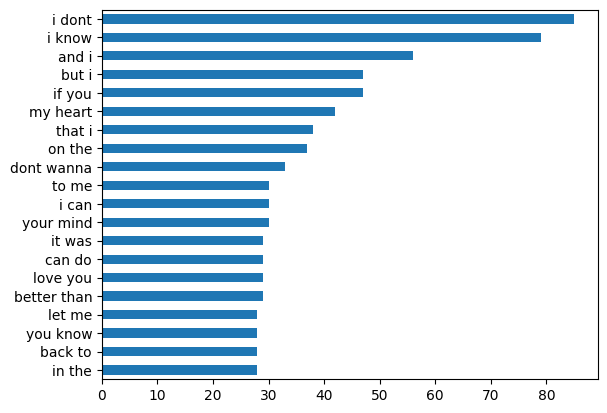

In [19]:
pd.Series(get_ngrams_from_series((i for i in ' '.join(preprocessed.Lyrics[preprocessed.Lyrics.notna()]).lower().split("\r\n")), 2)).value_counts()[:20][::-1].plot(kind='barh')

<Axes: >

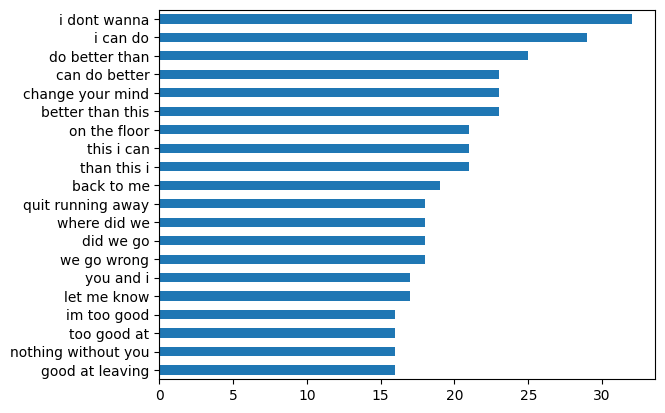

In [20]:
pd.Series(get_ngrams_from_series((i for i in ' '.join(preprocessed.Lyrics[preprocessed.Lyrics.notna()]).lower().split("\r\n")), 3)).value_counts()[:20][::-1].plot(kind='barh')

<Axes: title={'center': 'Number Of Songs Associated With Each Album'}>

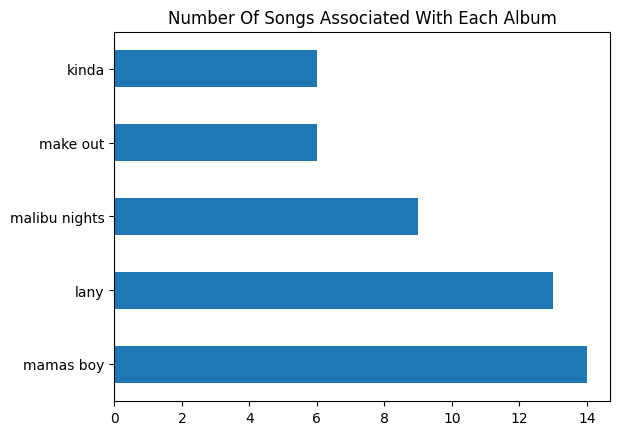

In [106]:
pd.Series(preprocessed.Album.value_counts()).plot(kind='barh', title = "Number Of Songs Associated With Each Album")

<Axes: title={'center': 'Distribution Of Different Amounts of Verses'}, ylabel='Density'>

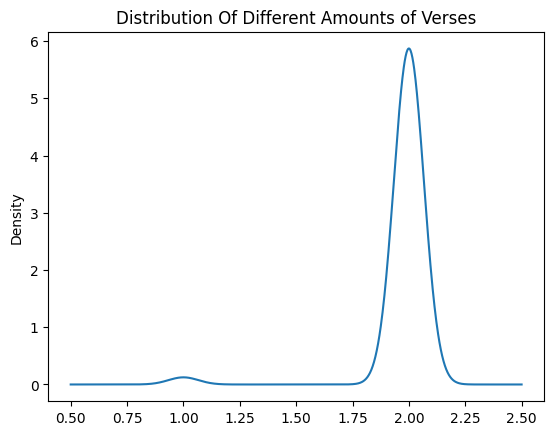

In [117]:
pd.Series(preprocessed.number_of_verses).plot(kind='kde', title = "Distribution Of Different Amounts of Verses")

<Axes: title={'center': 'Distribution Of Different Amounts of Choruses'}, ylabel='Density'>

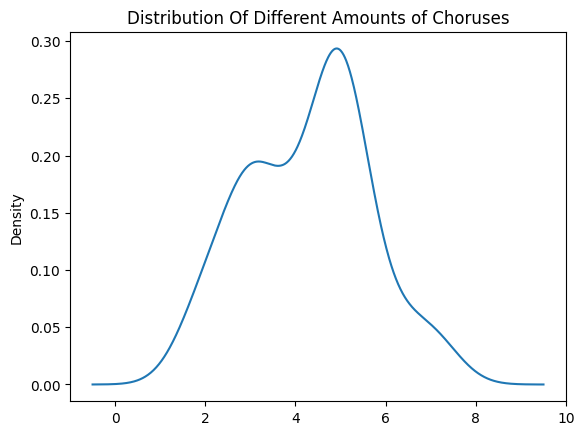

In [118]:
pd.Series(preprocessed.number_of_chorus).plot(kind='kde', title = "Distribution Of Different Amounts of Choruses")

In [92]:
#Album Mean Statistics DF
album_d = preprocessed.groupby(by='Album').mean()
album_d['Release_Year'] = 0
album_d.loc['lany','Release_Year']                         =2017
album_d.loc['make out','Release_Year']                  =2015
album_d.loc['kinda','Release_Year']                      =2016
album_d.loc['malibu nights','Release_Year']                 =2018
album_d.loc['mamas boy','Release_Year']                      =2020

<ipython-input-92-35a35cfcc025>:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [93]:
album_mean = album_d.sort_values(by='Release_Year')

album_year_index =[album + "  "+ str(year) for album,year in zip(album_mean.index,album_mean.Release_Year)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['Positive Sentiment'],
                    mode='lines+markers',
                    name='Mean Positive Sentiment Value',hovertext=album_mean['Release_Year']))
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['Negative Sentiment'],
                    mode='lines+markers',
                    name='Mean Negative Sentiment Value',hovertext=album_mean['Release_Year']))
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['Neutral Sentiment'],
                    mode='lines+markers',
                    name='Mean Neutral Sentiment Value',hovertext=album_mean['Release_Year']))

fig.update_layout(title='Album Sentiment Change Over The Years')
fig.show()

In [94]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['number_of_verses'],
                    mode='lines+markers',
                    name='Mean Verse Amount',hovertext=album_mean['Release_Year']))
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['number_of_chorus'],
                    mode='lines+markers',
                    name='Mean Chorus Amount',hovertext=album_mean['Release_Year']))

fig.update_layout(title='Album Chorus and Verse Count Change Over The Years')
fig.show()

In [95]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['views'],
                    mode='lines+markers',
                    name='Mean Verse Amount',hovertext=album_mean['Release_Year']))

fig.update_layout(title='Album Views Over The Years')
fig.show()

In [96]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['Average Word Length Per Line'],
                    mode='lines+markers',
                    name='Average Word Length Per Line',hovertext=album_mean['Release_Year']))

fig.update_layout(title='Average Word Length Per Line For Each Album')
fig.show()